# HashingVectoriser: hashing table size, hashing mechanism, etc.

This notebooks aims to illustrate the influence of the hashing table size, and of the approach proposed by   [Weinberger et al 2009](http://alex.smola.org/papers/2009/Weinbergeretal09.pdf) (alternating signs) on,

 - the text classification accuracy
 - the preservation of the inner product in the hashed space

In [1]:
import numpy as np

from sklearn.feature_extraction.text import (HashingVectorizer, CountVectorizer,
                                                          TfidfTransformer)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
np.random.seed(0)

categories = ['sci.space', 'comp.graphics']#, 'comp.windows.x','sci.crypt']
data_train = fetch_20newsgroups(subset='train', categories=categories)
data_test = fetch_20newsgroups(subset='test', categories=categories)

y_train, y_test = data_train.target, data_test.target

In [10]:
def _compute_scores(X_train, X_test):
    cmod = LogisticRegression().fit(X_train, y_train)
    return cmod.score(X_test, y_test)


def _check_inner_product(X_count, X_hash, n=5):
    """ Compute the relative error between the non-hashed
    and the hashed inner product on n*n random samples """
    assert X_count.shape[0] == X_hash.shape[0] # same number of samples
    n_samples = X_count.shape[0]
    
    idx_a = np.random.randint(0, n_samples, size=n)
    idx_b = np.mod(idx_a + np.random.randint(0, n_samples, size=n), n_samples)
    
    # compute the inner product for all combinations idx_a, idx_b
    val_count = X_count[idx_a,:].dot(X_count[idx_b, :].T)
    
    val_hash = X_hash[idx_a,:].dot(X_hash[idx_b, :].T)
    
    return np.abs(val_count - val_hash)/val_count


def _post_process(X, binary=False, norm=None):
    from sklearn.preprocessing import normalize
    if norm is not None:
        X = normalize(X, norm=norm, copy=True)
    if binary:
        X.data.fill(1)
    return X


def make_benchmark_plots(norm=None, binary=False, use_idf=False, **args):   
    
    cvect = CountVectorizer(**args)
    if use_idf:
        cvect = make_pipeline(cvect, TfidfTransformer(norm=None))
    
    X_count_train = cvect.fit_transform(data_train.data)
    X_count_test = cvect.transform(data_test.data)
    

    X_count_test = _post_process(X_count_test, norm=norm, binary=binary)
    X_count_train = _post_process(X_count_train, norm=norm, binary=binary)

    countvect_score = _compute_scores(X_count_train, X_count_test)
    
    n_features_list = np.logspace(0, 5, 25).astype(np.int)
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    for non_negative in [False, True, 'total']:
        scores = []
        dot_err = []
        for n_features in n_features_list:
            # The normalizatioon and/or converting to binary is done in _post_process
            hvect = HashingVectorizer(norm=None, non_negative=non_negative,
                                      n_features=n_features, binary=False, **args)
            if use_idf:
                hvect = make_pipeline(hvect, TfidfTransformer(norm=None))
            X_hash_train = hvect.fit_transform(data_train.data)
            X_hash_test = hvect.transform(data_test.data)
            X_hash_test = _post_process(X_hash_test, norm=norm, binary=binary)
            X_hash_train = _post_process(X_hash_train, norm=norm, binary=binary)

            scores.append(_compute_scores(X_hash_train, X_hash_test))
            dot_err.append(_check_inner_product(X_count_train, X_hash_train, n=10))
        label = 'non-negative='+str(non_negative)
        ax[0].plot(n_features_list, scores, label=label)
        ax[1].errorbar(n_features_list, [np.nanmean(el) for el in dot_err],
                       yerr=[np.std(el) for el in dot_err], label=label)
                  
    ax[0].axhline(countvect_score, c="k", ls="--", label='CountVectorizer baseline')
    ax[1].axhline(1, c='k', ls=':')
    ax[1].axhline(0, c='k', ls='--')
    ax[0].legend(loc=4)
    fig.suptitle("HashingVectorizer benchmark with {}/20 newsgroups "
                 "(binary={}, norm={}, use_idf={})".format(len(categories), binary, norm, use_idf),
                fontsize=14)
    ax[0].set_title('Classification score')
    ax[0].set_ylabel('Classifictation score')
    ax[1].set_title("Inner product conservation in the hashed space")
    ax[1].set_ylabel('Relative error for the inner product')
    ax[1].set_yscale('symlog', linscaley=2)
    ax[1].set_ylim(ymin=-0.05)
    for axi in ax:
        axi.set_xlabel('Hashing table size (n_features)')
        axi.set_xscale('log')
    

## A. Bag of Words (BOW)

/home/rth/.miniconda/envs/sklearn-test/lib/python3.5/site-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/rth/.miniconda/envs/sklearn-test/lib/python3.5/site-packages/numpy/ma/core.py:827: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)


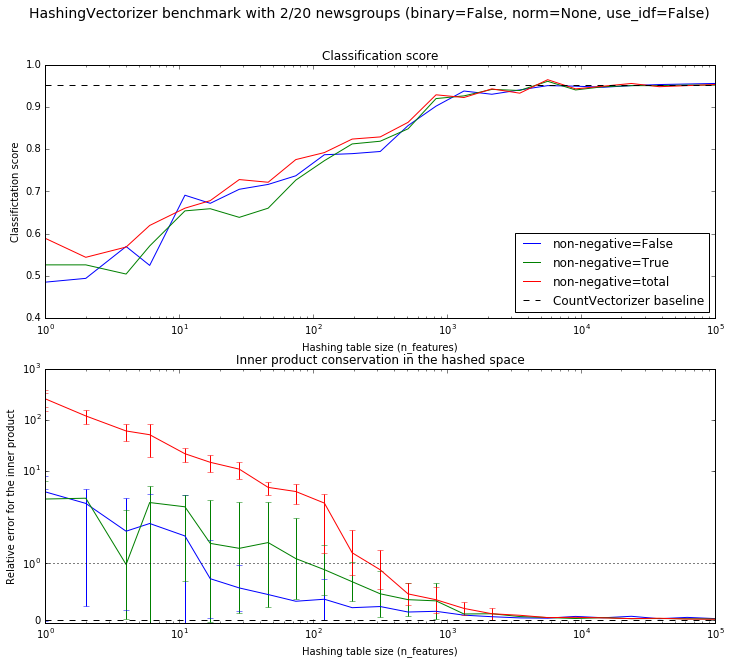

In [4]:
make_benchmark_plots(norm=None, binary=False, use_idf=False)

/home/rth/src/scikit-learn/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
/home/rth/.miniconda/envs/sklearn-test/lib/python3.5/site-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/rth/.miniconda/envs/sklearn-test/lib/python3.5/site-packages/numpy/ma/core.py:827: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)


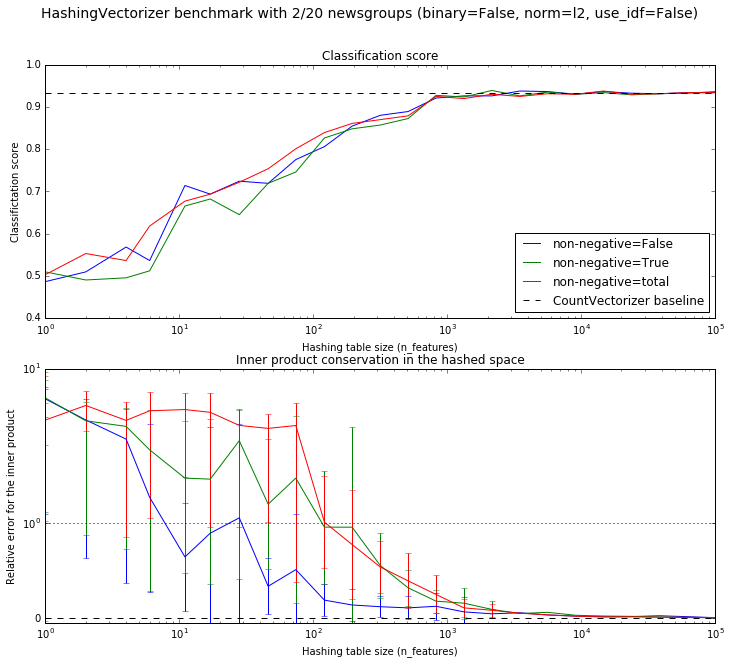

In [5]:
make_benchmark_plots(norm='l2', binary=False, use_idf=False)

/home/rth/.miniconda/envs/sklearn-test/lib/python3.5/site-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/rth/.miniconda/envs/sklearn-test/lib/python3.5/site-packages/numpy/ma/core.py:827: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)


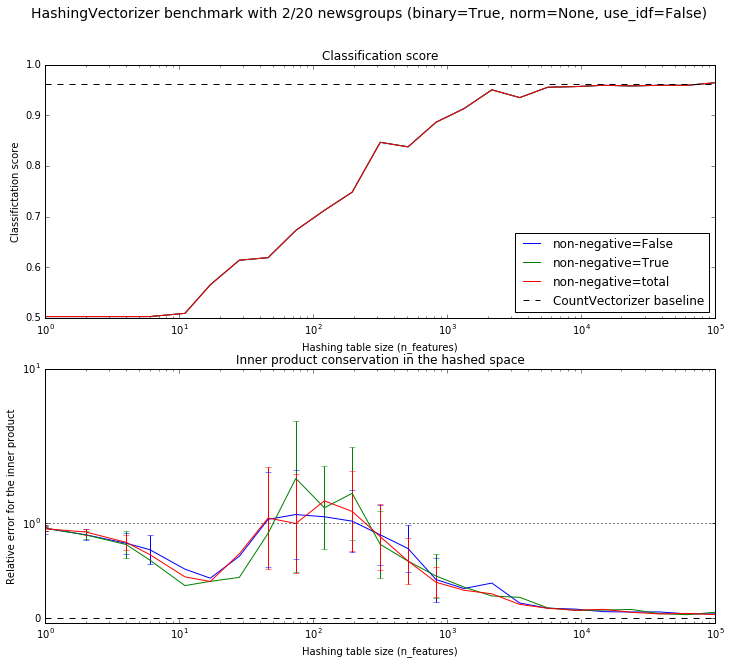

In [6]:
make_benchmark_plots(norm=None, binary=True, use_idf=False)

/home/rth/.miniconda/envs/sklearn-test/lib/python3.5/site-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/rth/.miniconda/envs/sklearn-test/lib/python3.5/site-packages/numpy/ma/core.py:827: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)


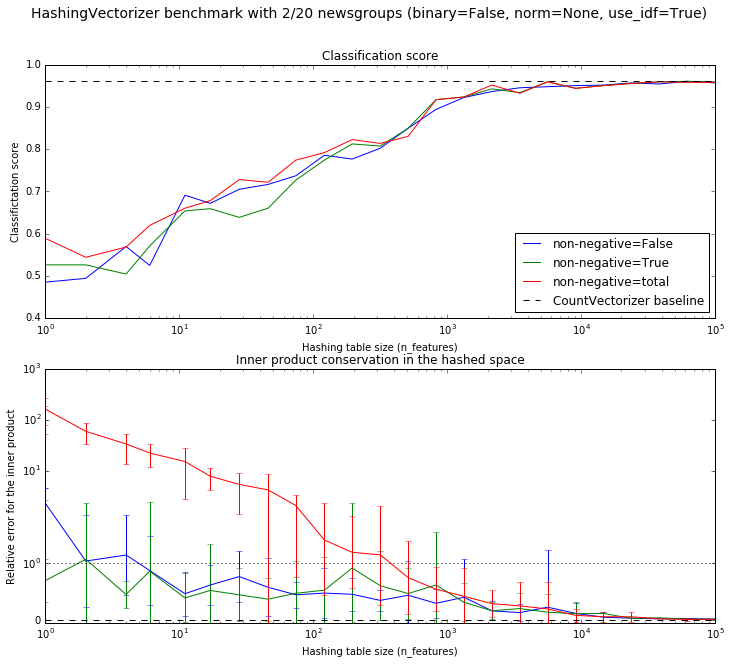

In [7]:
make_benchmark_plots(norm=None, binary=False, use_idf=True)

## B. 1-2 word n-grams

/home/rth/.miniconda/envs/sklearn-test/lib/python3.5/site-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/rth/.miniconda/envs/sklearn-test/lib/python3.5/site-packages/numpy/ma/core.py:827: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)


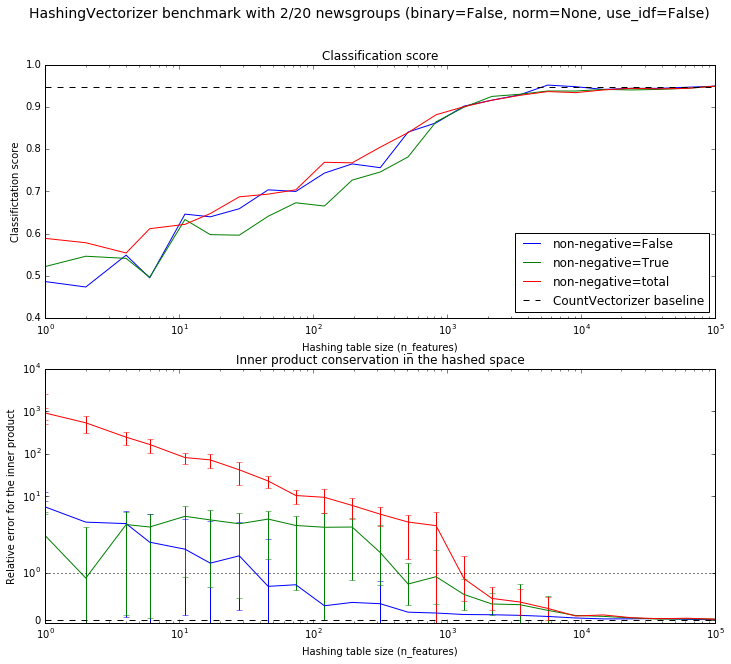

In [11]:
make_benchmark_plots(norm=None, binary=False, use_idf=False, ngram_range=(1,2))

## C. 4-char n-grams

/home/rth/.miniconda/envs/sklearn-test/lib/python3.5/site-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/rth/.miniconda/envs/sklearn-test/lib/python3.5/site-packages/numpy/ma/core.py:827: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)


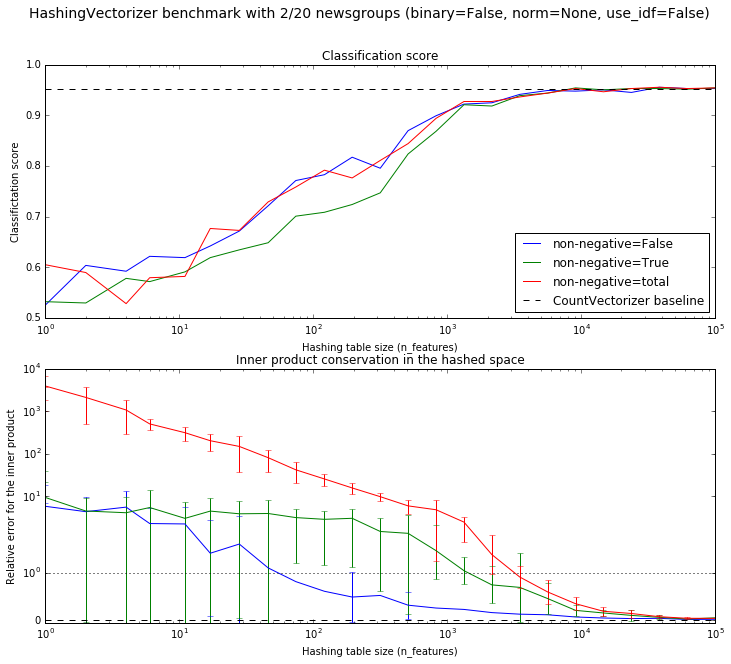

In [13]:
make_benchmark_plots(norm=None, binary=False, use_idf=False, ngram_range=(4,4), analyzer='char')

## Conclusions

  - The mechanism by Weinberger et al 2009 does not seem to matter for the text classification accuracy (here using Logistic Regression on the 2/20 newsgoups dataset), or if anything  it can occasionally make it slightly worse
  - this mechanism does indeed allow to preserve the inner product much better, however, 
     * this only matters for small hashing table sizes: `n_features < 1000` with BOW, `n_features < 10000` for 4-char ngrams, etc.
     * The inner product conservation still is mostly true even if we apply some other post normalization (e.g. L2 norm to compute the cosine similarity or TFIDF weights)
     * for binary counts, this algorithm has almost no impact
  - Setting `non_negative=True` make the inner product conservation much worse
  - The region where this mechanism becomes relevant, is also the region where the classification accuracy drops (i.e. need bigger hashing table).